### DICOM Inspection and Metadata Exploration

In this notebook, we begin by inspecting raw MRI data stored in the DICOM format.

**DICOM (Digital Imaging and Communications in Medicine)** is the clinical standard used by radiologists and hospital systems for storing and sharing medical imaging data. It contains both the image pixel data and rich metadata (e.g., patient details, scanner parameters, orientation, and acquisition settings).

We will use the `pydicom` library to:
- Read and explore DICOM metadata
- Sort slices and understand spatial layout
- Inspect individual image slices

In later steps, we will convert this DICOM data into the **NIfTI format**, which is commonly used in research and deep learning pipelines for preprocessing, analysis, and modeling.

> For now, our goal is to understand the structure of the data before moving to conversion and modeling.


In [1]:
# DICOM Series Inspection Notebook

## Import Libraries


import os
import pydicom
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
## Define Paths and Series UID

series_uid = "1.2.826.0.1.3680043.8.498.10070371997983281654193426002305027111"
# series_uid="1.2.826.0.1.3680043.8.498.10098743283291956051221530305664415374"
dicom_path = Path("/Users/sitani/Documents/neuro_psychiatry/mri_preprocessing/data/rsna_intracranial_aneurysm_detection/series") / series_uid
csv_path = Path("/Users/sitani/Documents/neuro_psychiatry/mri_preprocessing/data/rsna_intracranial_aneurysm_detection/train.csv")

In [3]:
# ## Load Patient-Level Metadata


df = pd.read_csv(csv_path)
patient_row = df[df['SeriesInstanceUID'] == series_uid]

if not patient_row.empty:
    display(patient_row)

    # Print aneurysm label
    label = int(patient_row.iloc[0]["Aneurysm Present"])
    if label == 1:
        print("Aneurysm present in this series.")
    else:
        print("No aneurysm detected in this series.")
else:
    print(f"Series UID {series_uid} not found in CSV.")


,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
25,1.2.826.0.1.3680043.8.498.10070371997983281654...,63,Female,MRI T2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


No aneurysm detected in this series.


In [4]:
# ## Read and Inspect One DICOM Slice


# %%
dcm_files = sorted([f for f in os.listdir(dicom_path) if f.endswith(".dcm")])
print(f"Found {len(dcm_files)} DICOM slices")
dcm = pydicom.dcmread(dicom_path / dcm_files[5])
print(dcm)

Found 30 DICOM slices
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 190
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.52862741740332976103834989698381968250
(0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
(0002, 0012) Implementation Class UID            UI: 1.2.840.114302.9
(0002, 0013) Implementation Version Name         SH: '7.5.2 b11'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.12837793916914941837661976604459650119
(0008, 0020) Study Date    

In [5]:
# ## Display Selected Metadata Fields


# %%
fields = {
"Series Description": dcm.get("SeriesDescription", "N/A"),
"Modality": dcm.get("Modality", "N/A"),
"Manufacturer": dcm.get("Manufacturer", "N/A"),
"Model": dcm.get("ManufacturerModelName", "N/A"),
"Echo Time (ms)": dcm.get("EchoTime", "N/A"),
"Repetition Time (ms)": dcm.get("RepetitionTime", "N/A"),
"Slice Thickness (mm)": dcm.get("SliceThickness", "N/A"),
"Spacing Between Slices (mm)": dcm.get("SpacingBetweenSlices", "N/A"),
"Pixel Spacing (mm)": dcm.get("PixelSpacing", "N/A"),
"Image Size": f"{dcm.get('Rows', '?')} x {dcm.get('Columns', '?')}",
"Patient Age": dcm.get("PatientAge", "N/A"),
"Patient Sex": dcm.get("PatientSex", "N/A"),
}
for k, v in fields.items():
   print(f"{k:30}: {v}")

Series Description            : sag t2
Modality                      : MR
Manufacturer                  : GE MEDICAL SYSTEMS
Model                         : Optima MR450w
Echo Time (ms)                : 98.08
Repetition Time (ms)          : 4484
Slice Thickness (mm)          : 4
Spacing Between Slices (mm)   : 5
Pixel Spacing (mm)            : [0.4102, 0.4102]
Image Size                    : 512 x 512
Patient Age                   : 063Y
Patient Sex                   : F


In [6]:
## Load and Process All DICOM Slices from Series
 
def load_series(series_path):
    dcm_files = sorted(Path(dicom_path).glob("*.dcm"))
    slices = [pydicom.dcmread(f) for f in dcm_files]
    return slices


slices = load_series(dicom_path)
print(f"Loaded {len(slices)} slices.")

Loaded 30 slices.


In [7]:
def sort_slices_by_position(slices):
    """
    Sort DICOM slices along the actual slice normal direction.
    Works for any orientation (axial, sagittal, coronal, oblique).
    """
    # Get orientation from first slice
    iop = [float(x) for x in slices[0].ImageOrientationPatient]
    row_cosines = np.array(iop[0:3])
    col_cosines = np.array(iop[3:6])
    normal = np.cross(row_cosines, col_cosines)
    
    def get_slice_position(ds):
        pos = np.array(ds.ImagePositionPatient, dtype=float)
        return np.dot(pos, normal)  # Project onto normal
    
    sorted_slices = sorted(slices, key=get_slice_position)
    return sorted_slices, sorted_slices[0]

slices_sorted, ref_ds = sort_slices_by_position(slices)


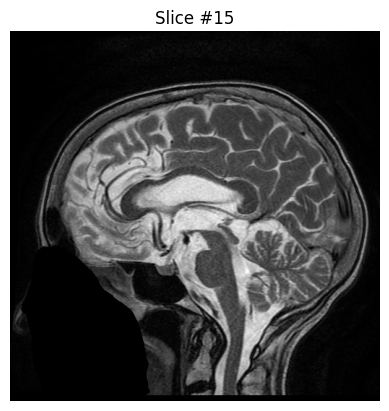

In [8]:
## Visualize the middle slice

mid_slice = slices_sorted[len(slices_sorted) // 2]

plt.imshow(mid_slice.pixel_array, cmap="gray")
plt.title(f"Slice #{mid_slice.InstanceNumber}")
plt.axis("off")
plt.show()


In [9]:
def get_voxel_spacing(slices):
    """
    Calculate voxel spacing (dx, dy, dz) from sorted DICOM slices.
    
    Args:
        slices: List of sorted pydicom datasets
        
    Returns:
        dx, dy, dz: Voxel spacing in mm
    """
    # dx, dy from PixelSpacing (in-plane resolution)
    dx, dy = map(float, slices[0].PixelSpacing)

    # Get normal vector to the slice plane using ImageOrientationPatient
    iop = [float(x) for x in slices[0].ImageOrientationPatient]
    row_cosines = np.array(iop[0:3])
    col_cosines = np.array(iop[3:6])
    normal = np.cross(row_cosines, col_cosines)

    # Compute dz from projection of position difference onto the normal
    positions = [np.array(s.ImagePositionPatient, dtype=float) for s in slices]
    distances = [abs(np.dot(positions[i+1] - positions[i], normal))
                 for i in range(len(positions) - 1)]
    dz = np.mean(distances)

    print(f"Voxel spacing (mm): dx={dx:.4f}, dy={dy:.4f}, dz={dz:.4f}")

    if abs(dx - dz) > 1e-2 or abs(dy - dz) > 1e-2:
        print("→ Volume is ANISOTROPIC")
    else:
        print("→ Volume is ISOTROPIC")
    
    # Check if SpacingBetweenSlices DICOM tag exists
    if hasattr(slices[0], 'SpacingBetweenSlices'):
        spacing_tag = float(slices[0].SpacingBetweenSlices)
        print(f"\nDICOM SpacingBetweenSlices tag: {spacing_tag:.4f} mm")
        print("→ This matches the calculated dz, so this tag could have also been used directly. It may not be available always")
    
    print("\nIndividual slice spacings:")
    for i in range(len(distances)):
        print(f"  Slice {i} → {i+1}: {distances[i]:.4f} mm")

    return dx, dy, dz
# First sort the slices properly
slices_sorted, ref_ds = sort_slices_by_position(slices)

# Then calculate spacing
dx, dy, dz = get_voxel_spacing(slices_sorted)

Voxel spacing (mm): dx=0.4102, dy=0.4102, dz=5.0000
→ Volume is ANISOTROPIC

DICOM SpacingBetweenSlices tag: 5.0000 mm
→ This matches the calculated dz, so this tag could have also been used directly. It may not be available always

Individual slice spacings:
  Slice 0 → 1: 5.0000 mm
  Slice 1 → 2: 5.0000 mm
  Slice 2 → 3: 5.0000 mm
  Slice 3 → 4: 5.0000 mm
  Slice 4 → 5: 4.9999 mm
  Slice 5 → 6: 5.0000 mm
  Slice 6 → 7: 5.0000 mm
  Slice 7 → 8: 5.0000 mm
  Slice 8 → 9: 5.0000 mm
  Slice 9 → 10: 5.0000 mm
  Slice 10 → 11: 5.0000 mm
  Slice 11 → 12: 5.0000 mm
  Slice 12 → 13: 5.0000 mm
  Slice 13 → 14: 5.0000 mm
  Slice 14 → 15: 5.0000 mm
  Slice 15 → 16: 5.0000 mm
  Slice 16 → 17: 5.0000 mm
  Slice 17 → 18: 5.0000 mm
  Slice 18 → 19: 4.9999 mm
  Slice 19 → 20: 5.0000 mm
  Slice 20 → 21: 5.0000 mm
  Slice 21 → 22: 5.0000 mm
  Slice 22 → 23: 5.0000 mm
  Slice 23 → 24: 5.0000 mm
  Slice 24 → 25: 5.0000 mm
  Slice 25 → 26: 4.9999 mm
  Slice 26 → 27: 5.0000 mm
  Slice 27 → 28: 5.0000 mm
  S

In [10]:
# ## Determine Orientation (Axial / Sagittal / Coronal)


# %%
def get_orientation(ds):
    orientation = ds.ImageOrientationPatient # 6 values
    row_cosines = np.array(orientation[:3])
    col_cosines = np.array(orientation[3:])
    normal = np.cross(row_cosines, col_cosines)
    abs_normal = np.abs(normal)
    max_index = np.argmax(abs_normal)
    if max_index == 0:
       return "Sagittal"
    elif max_index == 1:
       return "Coronal"
    else:
      return "Axial"


# %%
orientation = get_orientation(slices[0])
print(f"Slice Orientation: {orientation}")

Slice Orientation: Sagittal


In [11]:
## Infer orientation from Series Description
series_desc = dcm.get("SeriesDescription", "").lower()
if "sag" in series_desc:
    orientation = "Sagittal"
elif "cor" in series_desc:
    orientation = "Coronal"
elif "ax" in series_desc or "tra" in series_desc:
    orientation = "Axial"
else:
    orientation = "Unknown (no orientation keyword found)"

print(f"Inferred Orientation from Series Description: {orientation}")


Inferred Orientation from Series Description: Sagittal
